# The Julia Opportunistic Network Simulator

In [1]:
#using Pkg
#Pkg.instantiate()

push!(LOAD_PATH, "../src")
push!(LOAD_PATH, "src")

using Random
using DataFrames
using JONS


## Configuration

In [2]:
MOVEMENT_FILE="data/large_1.one"
SCAN_INTERVAL=2.0
NET_RANGE=100
ANIMATION_STEPS = 20.0
VIZ = false
POSLOG = false

false

In [3]:
one_scenario = parse_one_movement(MOVEMENT_FILE)

OneScenario(duration=3600.0, nn=17, w=1000.0, h=1000.0, #movements=18012)

In [4]:
Random.seed!(1)
#plotlyjs()

# configure network
network = NetworkSettings(NET_RANGE, 54000000)

# configure nodes
epidemic = EpidemicRouter(10000, SCAN_INTERVAL)
saw = SprayAndWaitRouter(10000, SCAN_INTERVAL, 7)
nodes = generate_nodes(one_scenario.nn, network, epidemic)

msggenconfig = MessageGeneratorConfig("M", (80, 120), (20.0, 20.0), (6, 15), (17, 17), Burst)
config = Dict()
config["visualize"] = VIZ
config["poslogger"] = POSLOG
#sim = NetSim(last_move_time + 1, (Float32(WORLD_SIZE[1]), Float32(WORLD_SIZE[2])), nodes, movements, MessageGeneratorConfig[msggenconfig], config)
sim = NetSim(one_scenario.duration + 1, (one_scenario.w, one_scenario.h), nodes, one_scenario.movements, MessageGeneratorConfig[msggenconfig], config)

sim_init(sim)
sim_run(sim)

┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


┌ Info: real: 4629 milliseconds sim: 3602 rate: 778.14 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 4 seconds, 629 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76


## Results

In [5]:
DataFrame(net_stats(sim))

Row,drop,rx,tx
,Int64,Int64,Int64
1,0,104363,104363


In [6]:
DataFrame(bundle_stats(sim))

Row,aborted,created,delivered,delivery_prob,dropped,dups,hops_avg,latency_avg,overhead_ratio,relayed,removed,started
,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64
1,0,1800,1664,0.924444,0,81287,3.07151,241.187,61.7181,104363,0,105808


In [7]:
sim_viz(sim)

## Batch Simulation

In [68]:
const NUM_RUNS = 3
#plotlyjs()

# configure network
network = NetworkSettings(NET_RANGE, 54000000)

# configure nodes
routers = [EpidemicRouter(10000, SCAN_INTERVAL), 
  SprayAndWaitRouter(10000, SCAN_INTERVAL, 7), 
  SprayAndWaitRouter(10000, SCAN_INTERVAL, 2),
  SprayAndWaitRouter(10000, SCAN_INTERVAL, 1)]
#run_idx = 1

dfs = []

@time for run_idx in 1:NUM_RUNS
  Random.seed!(run_idx)

  for r in routers
    println("#run ", run_idx, " w/ router: ", r)
    r_strategy = string(r)
    if r_strategy == "SprayAndWait"
      r_strategy = "SprayAndWait_" * string(r.core.config["copies"])
    end
    #run_idx += 1

    nodes = generate_nodes(one_scenario.nn, network, r)
    
    msggenconfig = MessageGeneratorConfig("M", (80, 120), (20.0, 40.0), (6, 15), (17, 17), Burst)
    config = Dict()
    config["visualize"] = VIZ
    config["poslogger"] = POSLOG
    #sim = NetSim(last_move_time + 1, (Float32(WORLD_SIZE[1]), Float32(WORLD_SIZE[2])), nodes, movements, MessageGeneratorConfig[msggenconfig], config)
    sim = NetSim(one_scenario.duration + 1, (one_scenario.w, one_scenario.h), nodes, one_scenario.movements, MessageGeneratorConfig[msggenconfig], config)
    
    sim_init(sim)
    sim_run(sim)

    run_df = DataFrame(bundle_stats(sim))
    colname = "Strategy"
    #run_df[!, colname] = string(r)
    insertcols!(run_df, 1, colname => r_strategy)
    colname = "run"
    insertcols!(run_df, 2, colname => run_idx)    
    push!(dfs, run_df)
  end
end

df = popfirst!(dfs)
for d in dfs
  df = vcat(df, d)
end
df

#run 1 w/ router: Epidemic


┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 1 w/ router: SprayAndWait


┌ Info: real: 2193 milliseconds sim: 3602 rate: 1642.5 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 2 seconds, 193 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 1 w/ router: SprayAndWait


┌ Info: real: 822 milliseconds sim: 3602 rate: 4382.0 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 822 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 1 w/ router: SprayAndWait


┌ Info: real: 474 milliseconds sim: 3602 rate: 7599.16 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 474 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 2 w/ router: Epidemic


┌ Info: real: 281 milliseconds sim: 3602 rate: 12818.51 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 281 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 2 w/ router: SprayAndWait


┌ Info: real: 2268 milliseconds sim: 3602 rate: 1588.18 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 2 seconds, 268 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 2 w/ router: SprayAndWait


┌ Info: real: 678 milliseconds sim: 3602 rate: 5312.68 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 678 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 2 w/ router: SprayAndWait


┌ Info: real: 506 milliseconds sim: 3602 rate: 7118.58 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 506 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 3 w/ router: Epidemic


┌ Info: real: 275 milliseconds sim: 3602 rate: 13098.18 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 275 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 3 w/ router: SprayAndWait


┌ Info: real: 2321 milliseconds sim: 3602 rate: 1551.92 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 2 seconds, 321 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 3 w/ router: SprayAndWait


┌ Info: real: 730 milliseconds sim: 3602 rate: 4934.25 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 730 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


#run 3 w/ router: SprayAndWait


┌ Info: real: 468 milliseconds sim: 3602 rate: 7696.58 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 468 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76
┌ Info: initializing simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:5
┌ Info: running simulation
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:45


 11.372024 seconds (57.32 M allocations: 2.152 GiB, 4.06% gc time, 0.56% compilation time)


┌ Info: real: 282 milliseconds sim: 3602 rate: 12773.05 s/s
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:75
┌ Info: simulation finished in 282 milliseconds
└ @ JONS /Users/lbaumgaertner/LocalCode/gh0st42/JONS.jl/src/simulation.jl:76


Row,Strategy,run,aborted,created,delivered,delivery_prob,dropped,dups,hops_avg,latency_avg,overhead_ratio,relayed,removed,started
,String,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64
1,Epidemic,1,0,1170,1082,0.924786,0,52735,3.09889,242.984,61.5739,67705,0,68635
2,SprayAndWait_7,1,0,1200,1095,0.9125,0,3176,2.0,287.206,6.91142,8663,0,8724
3,SprayAndWait_2,1,0,1170,1054,0.900855,0,0,2.0,350.93,1.02751,2137,0,2151
4,SprayAndWait_1,1,0,1120,0,0.0,0,0,NaN,NaN,NaN,0,0,0
5,Epidemic,2,0,1200,1102,0.918333,0,53061,3.07623,241.502,60.9102,68225,0,69178
6,SprayAndWait_7,2,0,1200,1077,0.8975,0,3182,2.0,285.098,7.02228,8640,0,8702
7,SprayAndWait_2,2,0,1240,1116,0.9,0,0,2.0,351.313,1.02778,2263,0,2276
8,SprayAndWait_1,2,0,1170,0,0.0,0,0,NaN,NaN,NaN,0,0,0
9,Epidemic,3,0,1180,1092,0.925424,0,54272,3.07143,243.315,62.6392,69494,0,70472


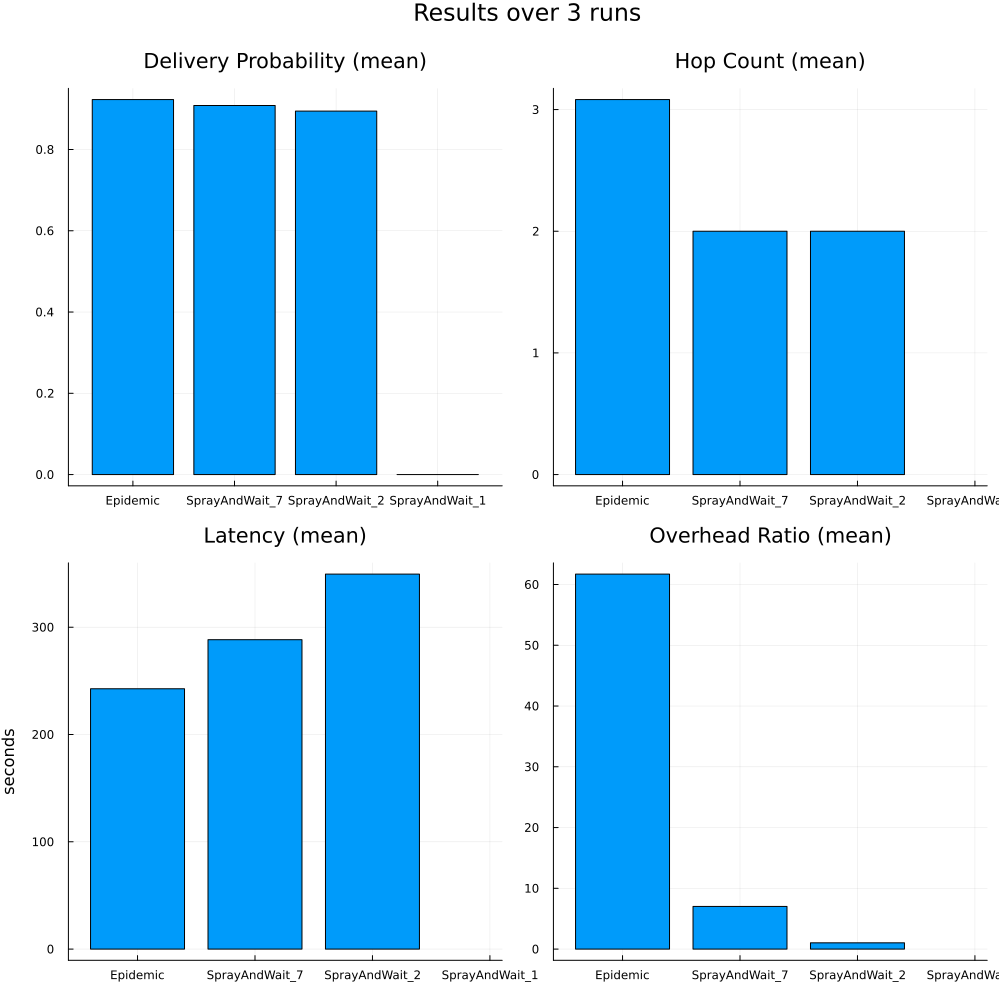

In [61]:
using Plots
using Statistics

g_strat = groupby(df, :Strategy)
df1 = combine(g_strat, [:delivery_prob] .=> mean)
p1 = bar(df1[!,"Strategy"], df1[!, "delivery_prob_mean"], label="")
title!("Delivery Probability (mean)")

df1 = combine(g_strat, [:hops_avg] .=> mean)
p2 = bar(df1[!,"Strategy"], df1[!, "hops_avg_mean"], label="")
title!("Hop Count (mean)")

df1 = combine(g_strat, [:latency_avg] .=> mean)
p3 = bar(df1[!,"Strategy"], df1[!, "latency_avg_mean"], label="")
title!("Latency (mean)")
ylabel!("seconds")

df1 = combine(g_strat, [:overhead_ratio] .=> mean)
p4 = bar(df1[!,"Strategy"], df1[!, "overhead_ratio_mean"], label="")
title!("Overhead Ratio (mean)")

plot(p1,p2, p3, p4, layout=(2,2), size=(1000,1000), plot_title="Results over " * string(NUM_RUNS) * " runs")

